# Microsoft Stock Time-Series Analysis

In [325]:
# Importing Packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [326]:
# Reading in the Data, setting the datetime as index

df = pd.read_csv('Data/MSFT.csv', index_col='Date', parse_dates=True)

## Exploratory Data Analysis

In [327]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063503,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061889,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400


In [328]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-19,371.489990,373.260010,369.839996,373.260010,373.260010,20603700
2023-12-20,375.000000,376.029999,370.529999,370.619995,370.619995,26316700
2023-12-21,372.559998,374.410004,370.040009,373.540009,373.540009,17708000
2023-12-22,373.679993,375.179993,372.709991,374.579987,374.579987,17091100
2023-12-26,375.000000,376.940002,373.500000,374.660004,374.660004,12673100


In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9524 entries, 1986-03-13 to 2023-12-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9524 non-null   float64
 1   High       9524 non-null   float64
 2   Low        9524 non-null   float64
 3   Close      9524 non-null   float64
 4   Adj Close  9524 non-null   float64
 5   Volume     9524 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 520.8 KB


In [330]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9524.000000,9524.000000,9524.000000,9524.000000,9524.000000,9.524000e+03
mean,52.820706,53.383050,52.249194,52.836106,47.328041,5.733974e+07
std,78.772359,79.565262,77.951983,78.800088,78.820530,3.815727e+07
min,0.088542,0.092014,0.088542,0.090278,0.055969,2.304000e+06
25%,5.523438,5.615967,5.446045,5.529297,3.427964,3.300222e+07
50%,27.200001,27.469999,26.969999,27.219999,19.103065,5.049085e+07
75%,45.437500,46.060626,44.870001,45.471562,35.911209,7.123635e+07
max,383.760010,384.299988,378.160004,382.700012,382.700012,1.031789e+09


In [331]:
# Average Stock Price in the past 52 weeks

rolling_mean_52weeks = df['Close'].rolling(window=52, min_periods=1).mean()
rolling_mean_52weeks

Date
1986-03-13      0.097222
1986-03-14      0.098958
1986-03-17      0.100116
1986-03-18      0.100043
1986-03-19      0.099653
                 ...    
2023-12-19    356.371157
2023-12-20    357.205003
2023-12-21    358.045772
2023-12-22    358.934041
2023-12-26    359.746348
Name: Close, Length: 9524, dtype: float64

In [332]:
# Creating a Series of MSFT close price

df_close = df['Close']
df_close.head()

Date
1986-03-13    0.097222
1986-03-14    0.100694
1986-03-17    0.102431
1986-03-18    0.099826
1986-03-19    0.098090
Name: Close, dtype: float64

### Time-Series Visualization

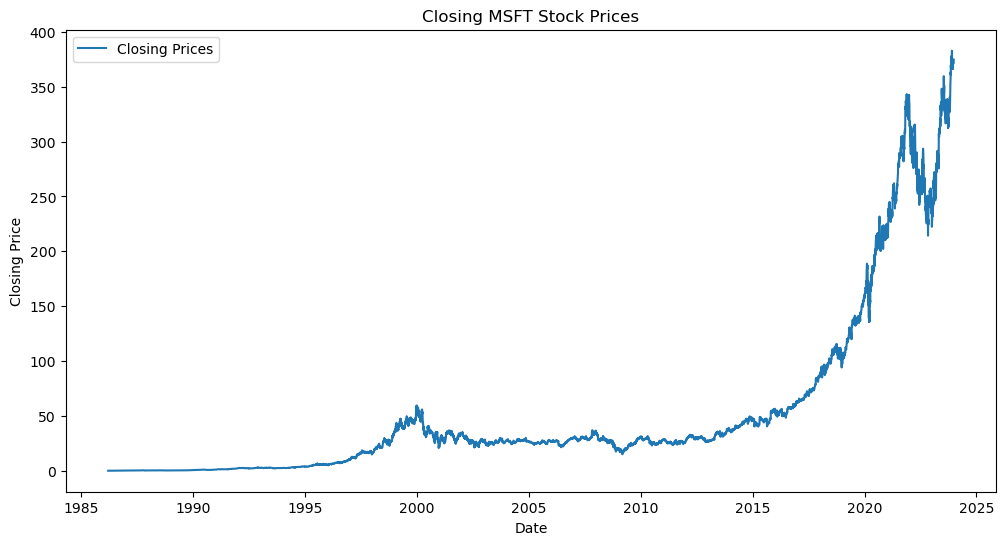

In [333]:
plt.figure(figsize=(12, 6))

plt.plot(df_close.index, df_close, label='Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing MSFT Stock Prices')
plt.legend()
plt.show();

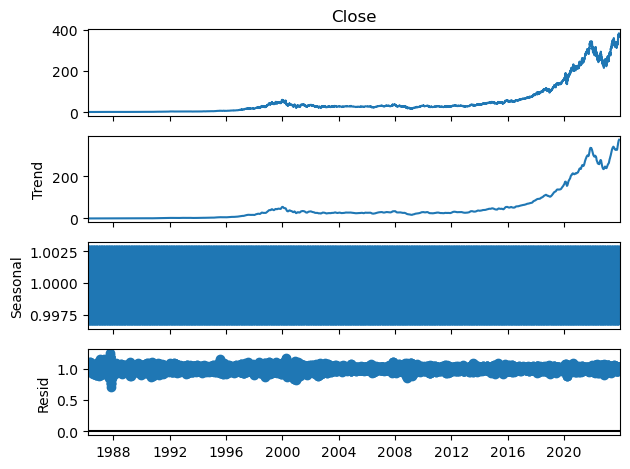

In [334]:
# Decompose the time series data into trend, seasonality, and residual components to identify patterns

result = seasonal_decompose(df_close, model='multiplicative', period=30)
result.plot()
plt.show();

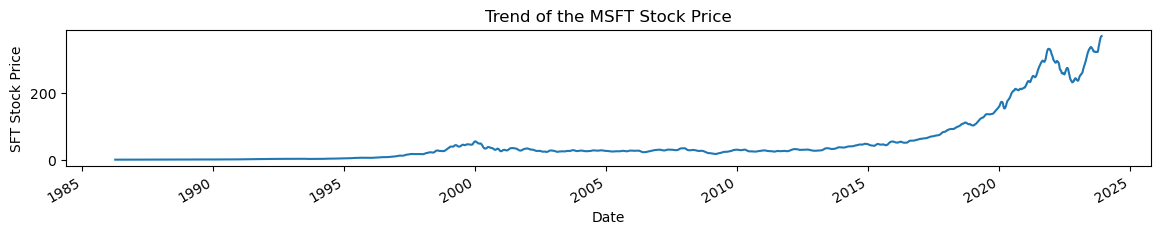

In [335]:
# Looking at the trend with more detail

decomposition_trend = result.trend
ax = decomposition_trend.plot(figsize=(14, 2))
ax.set_xlabel('Date')
ax.set_ylabel('SFT Stock Price')
ax.set_title('Trend of the MSFT Stock Price')
plt.show();

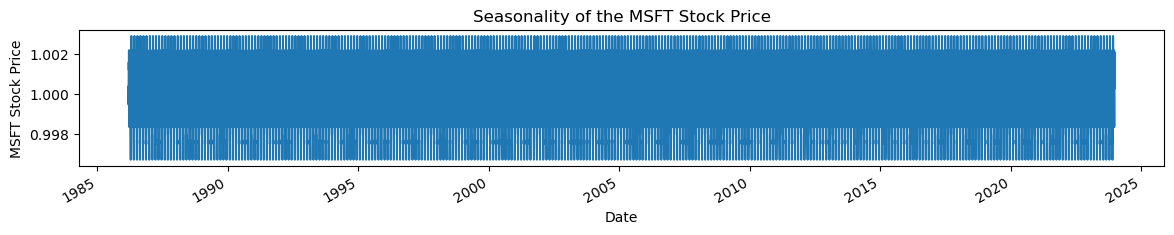

In [336]:
# Looking at the seasonality with more detail

decomposition_seasonality = result.seasonal
ax = decomposition_seasonality.plot(figsize=(14, 2))
ax.set_xlabel('Date')
ax.set_ylabel('MSFT Stock Price')
ax.set_title('Seasonality of the MSFT Stock Price')
plt.show();

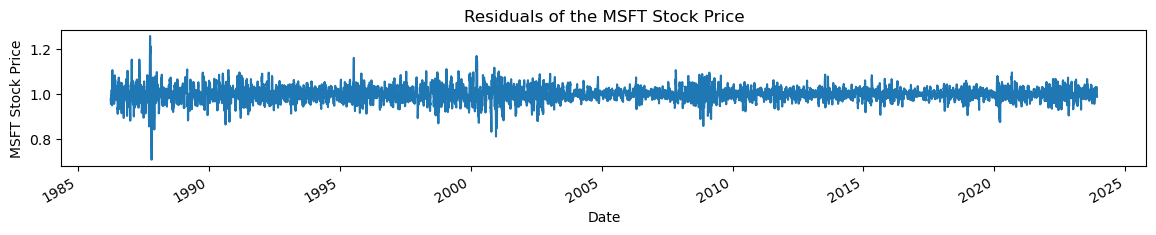

In [337]:
# Looking at the residuals with more detail

decomposition_residuals = result.resid
ax = decomposition_residuals.plot(figsize=(14, 2))
ax.set_xlabel('Date')
ax.set_ylabel('MSFT Stock Price')
ax.set_title('Residuals of the MSFT Stock Price')
plt.show();

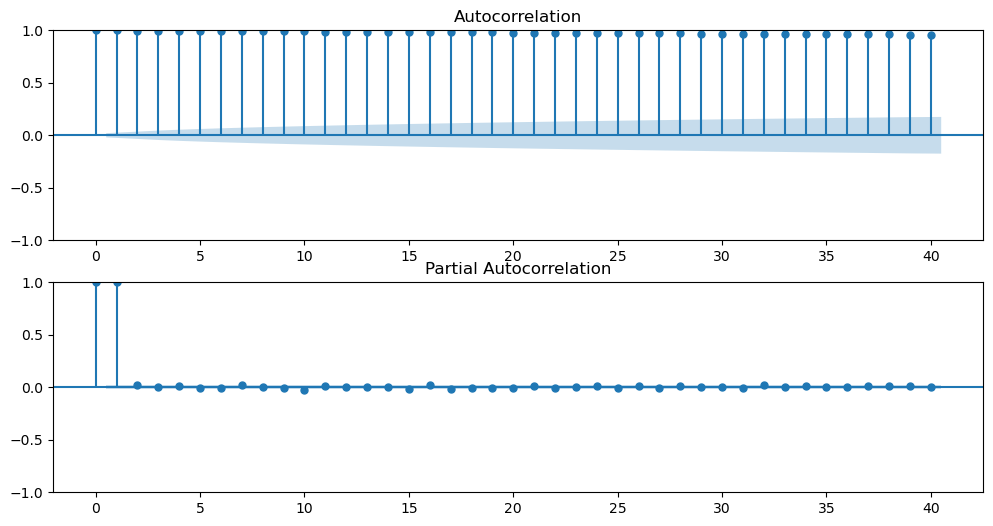

In [338]:
# Check autocorrelation and partial autocorrelation functions to identify lag dependencies

plt.figure(figsize=(12, 6))
plot_acf(df_close, lags=40, ax=plt.subplot(2, 1, 1))
plot_pacf(df_close, lags=40, ax=plt.subplot(2, 1, 2))
plt.show();

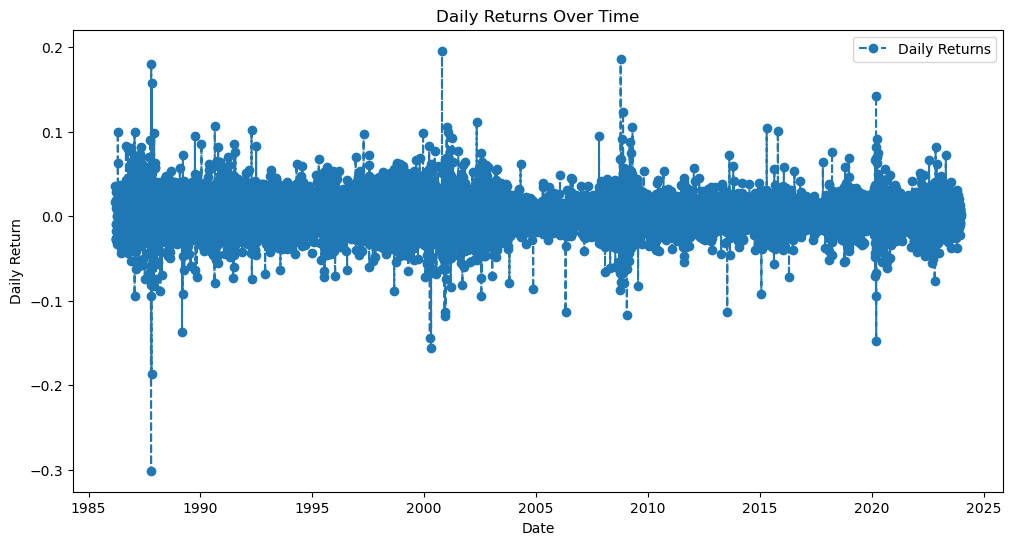

In [339]:
# Calculate and visualize daily returns to understand volatility

df['Daily_Return'] = df['Close'].pct_change()
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Daily_Return'], label='Daily Returns', linestyle='--', marker='o')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns Over Time')
plt.legend()
plt.show();

## Stationarity

### Testing for Stationarity: Dickey-Fuller Test

In [340]:
result_df = adfuller(df_close)

print('Results of Dickey-Fuller Test on MSFT Stock Price')
print('ADF Statistic: %f' % result_df[0])
print('P-Value: %f' % result_df[1])
print('Critical Values:')
for key, value in result_df[4].items():
    print('\t%s: %.3f' % (key, value))

Results of Dickey-Fuller Test on MSFT Stock Price
ADF Statistic: 4.149616
P-Value: 1.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


#### Takeaway

Dickey-Fuller test is a statistical test used to determine the presence of a unit root in a time series data, which is indicative of non-stationarity.

- Test statistic = 4.15


- P-value = 1.00

Since P-Value is not less than .05, we fail to reject the null hypothesis. This implies that the time-series dataset is not stationary

## Modeling

### Baseline Model: Naive Model

In [341]:
df_close.shape

(9524,)

In [342]:
df_close.shift(2).shape

(9524,)

In [343]:
df_naive = pd.DataFrame(np.hstack((df_close.values.reshape(-1, 1),
                                   df_close.shift().values.reshape(-1, 1),
                                   df_close.shift(periods=2).values.reshape(-1, 1))),
                columns=['original', 'shifted_one_period', 'shifted_two_periods'])

df_naive.head()

,original,shifted_one_period,shifted_two_periods
0,0.097222,NaN,NaN
1,0.100694,0.097222,NaN
2,0.102431,0.100694,0.097222
3,0.099826,0.102431,0.100694
4,0.098090,0.099826,0.102431


In [344]:
np.sqrt(mean_squared_error(df_naive['original'][1:], df_naive['shifted_one_period'][1:]))

1.692850810299829

In [345]:
np.sqrt(mean_squared_error(df_naive['original'][2:], df_naive['shifted_two_periods'][2:]))

2.272144322401009

In [346]:
# cutoff point for Train Test Split

cutoff = round(df_close.shape[0]*0.8)
cutoff

7619

In [347]:
# Train Test Split

train = df_close[:cutoff]
test = df_close[cutoff:]

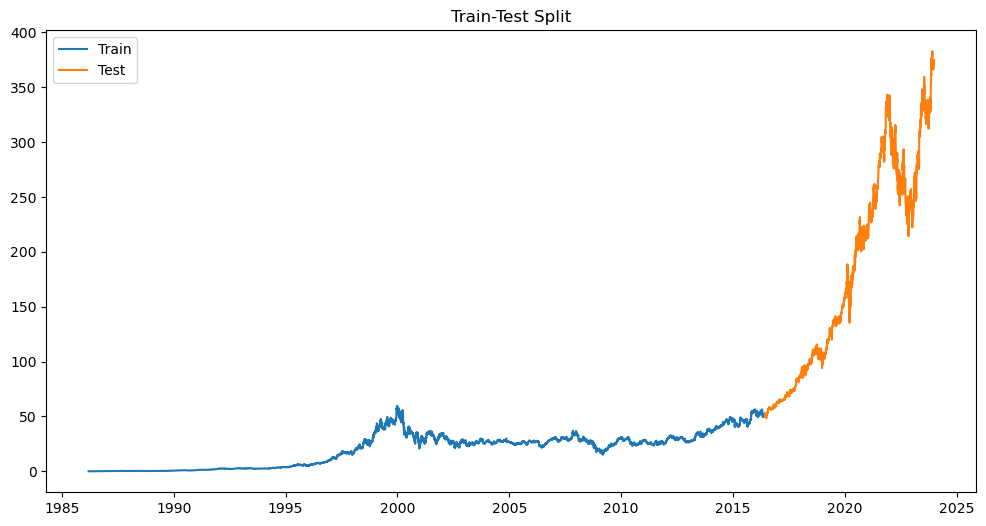

In [348]:
# Visualizing Train and Test dataset

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.set_title('Train-Test Split')
plt.legend()
plt.show();

In [349]:
naive = train.shift(1)
naive.head()

Date
1986-03-13         NaN
1986-03-14    0.097222
1986-03-17    0.100694
1986-03-18    0.102431
1986-03-19    0.099826
Name: Close, dtype: float64

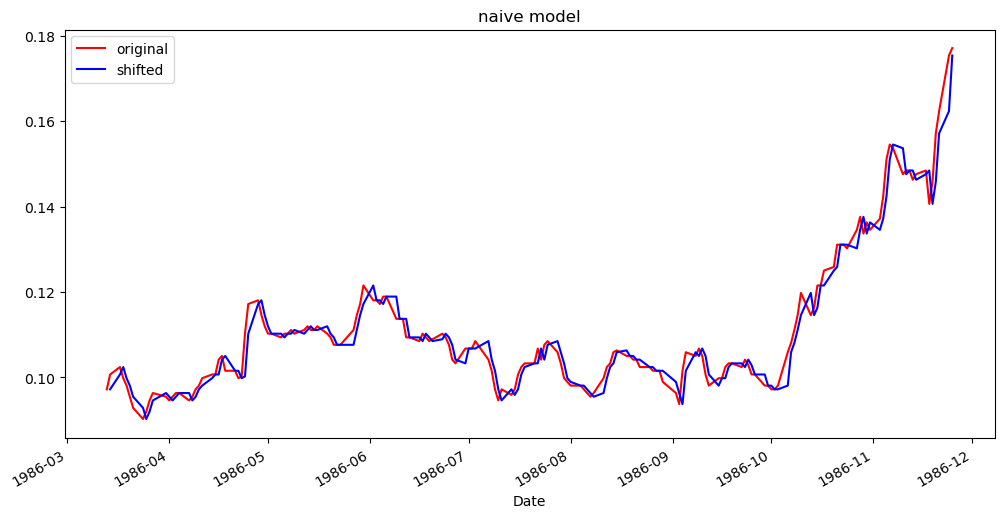

In [350]:
fig, ax = plt.subplots(figsize=(12, 6))

train[0:180].plot(ax=ax, c='r', label='original')
naive[0:180].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive model')
ax.legend()
plt.show();

In [351]:
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

0.5185768725506724

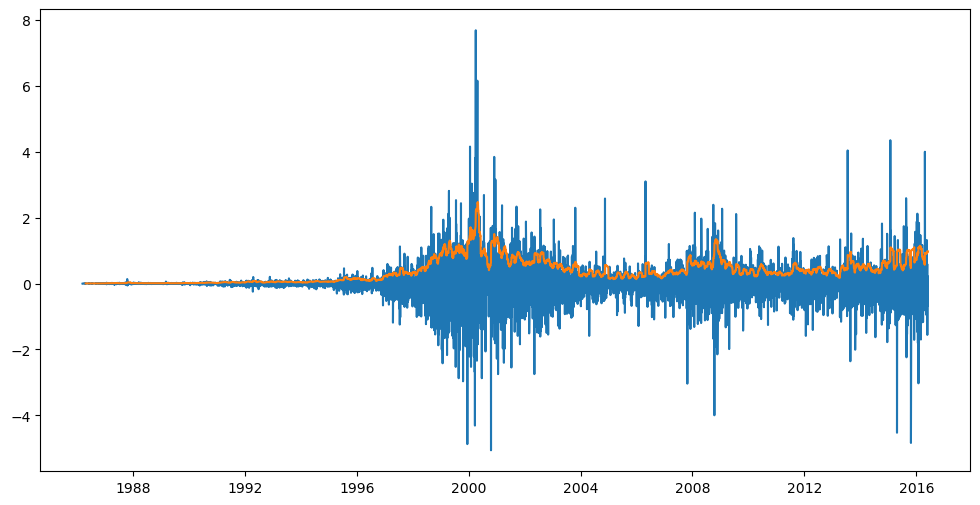

In [352]:
fig, ax = plt.subplots(figsize=(12, 6))

residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

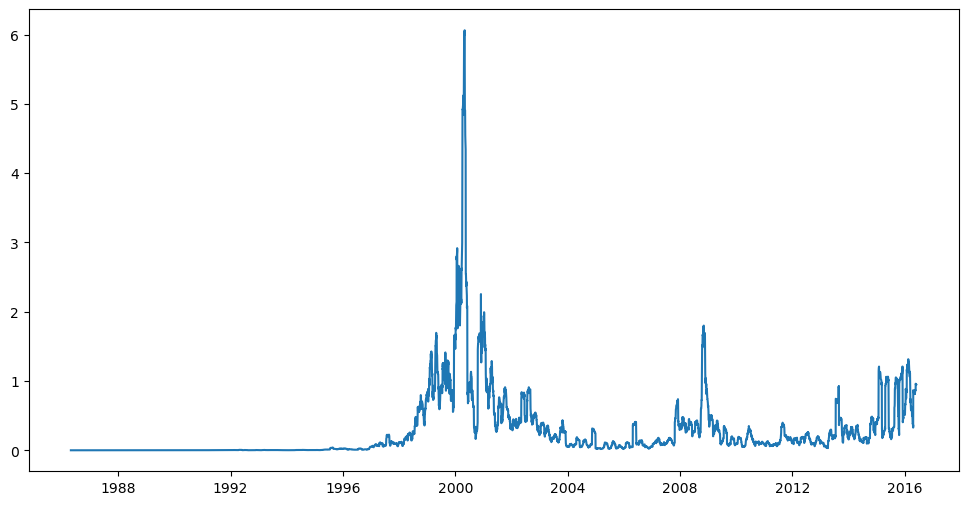

In [353]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(residuals.index, residuals.rolling(30).var());

In [354]:
p_val = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val}")
print('so we can safely assume that the differenced data is stationary')

The p-value associated with the Dickey-Fuller statistical test is 5.840222031299381e-29
so we can safely assume that the differenced data is stationary


### ARIMA

In [355]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

ar1_predict = ar_1.predict(typ='levels')
ar1_predict

Date
1986-03-13     0.000000
1986-03-14     0.097222
1986-03-17     0.100617
1986-03-18     0.102393
1986-03-19     0.099884
                ...    
2016-05-25    51.555556
2016-05-26    52.108297
2016-05-27    51.895077
2016-05-31    52.310506
2016-06-01    52.984986
Name: predicted_mean, Length: 7619, dtype: float64

In [356]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 7619
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5805.127
Date:                Thu, 28 Dec 2023   AIC                          11614.254
Time:                        10:53:12   BIC                          11628.131
Sample:                             0   HQIC                         11619.016
                               - 7619                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0221      0.006     -3.640      0.000      -0.034      -0.010
sigma2         0.2688      0.001    209.617      0.000       0.266       0.271
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            141984.73
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              99.93   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [357]:
ar_1.aic

11614.254494968627

In [358]:
np.sqrt(mean_squared_error(train, ar1_predict))

0.5184176140152905

### Random Walk Model

In [359]:
random_walk = ARIMA(train, order=(0, 1, 0)).fit()
random_walk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 7619
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5806.985
Date:                Thu, 28 Dec 2023   AIC                          11615.969
Time:                        10:53:13   BIC                          11622.907
Sample:                             0   HQIC                         11618.350
                               - 7619                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2689      0.001    209.823      0.000       0.266       0.271
===================================================================================
Ljung-Box (L1) (Q):                   3.78   Jarque-Bera (JB):            142210.86
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):              99.90   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [360]:
random_walk.aic

11615.969037221981

In [361]:
y_hat_rw = random_walk.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

0.5185440358475445

### LSTM Model

In [362]:
#training_set = df.iloc[:800, 1:2].values
#test_set = df.iloc[800:, 1:2].values

In [363]:
# Scaling Data

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(train).reshape(-1, 1))
scaled_data.shape

(7619, 1)

In [364]:
# Create data structure with 60 time-steps and 1 output

train_size = int(len(scaled_data)*0.80)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data), :1]

In [365]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [366]:
time_step = 100
X_train_lstm, y_train_lstm = create_dataset(train_data, time_step)
X_test_lstm, y_test_lstm = create_dataset(test_data, time_step)

In [370]:
# Building the LSTM model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (X_train_lstm.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [371]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           10400     
                                                                 
 dropout_8 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_9 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_14 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_10 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_15 (LSTM)              (None, 50)               

In [372]:
# Train the model

model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


2023-12-28 10:54:31.459440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-28 10:54:31.815581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-28 10:54:32.421340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-28 10:54:32.908179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-28 10:54:33.356831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-28 10:54:33.864193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-28 10:54:36.729148: I tensorflow/core/grappler/optimizers/cust

94/94 [==============================] - 37s 227ms/step - loss: 0.0094
Epoch 2/100
94/94 [==============================] - 8s 80ms/step - loss: 0.0012
Epoch 3/100
94/94 [==============================] - 8s 81ms/step - loss: 9.4852e-04
Epoch 4/100
94/94 [==============================] - 8s 80ms/step - loss: 9.1844e-04
Epoch 5/100
94/94 [==============================] - 8s 80ms/step - loss: 8.1018e-04
Epoch 6/100
94/94 [==============================] - 8s 80ms/step - loss: 7.7287e-04
Epoch 7/100
94/94 [==============================] - 8s 81ms/step - loss: 6.2022e-04
Epoch 8/100
94/94 [==============================] - 8s 81ms/step - loss: 6.0726e-04
Epoch 9/100
94/94 [==============================] - 8s 81ms/step - loss: 5.1910e-04
Epoch 10/100
94/94 [==============================] - 8s 81ms/step - loss: 4.4253e-04
Epoch 11/100
94/94 [==============================] - 8s 81ms/step - loss: 4.2189e-04
Epoch 12/100
94/94 [==============================] - 8s 82ms/step - loss: 4.1213

In [373]:
train_predict = model.predict(X_train_lstm)
test_predict = model.predict(X_test_lstm)

2023-12-28 11:08:19.369399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-28 11:08:19.494108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-28 11:08:20.004709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-28 11:08:20.498500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-28 11:08:20.963329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 4s 85ms/step


In [374]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [375]:
# Evaluate the Model

print(np.sqrt(mean_squared_error(y_train_lstm, train_predict)))
print(np.sqrt(mean_squared_error(y_test_lstm, test_predict)))

20.681065132783765
35.02327980947686


In [376]:
# Plotting the Results

look_back = 100

trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(train_predict) + look_back, :] = train_predict

In [377]:
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back)*2 + 1 : len(scaled_data) - 1, :] = test_predict

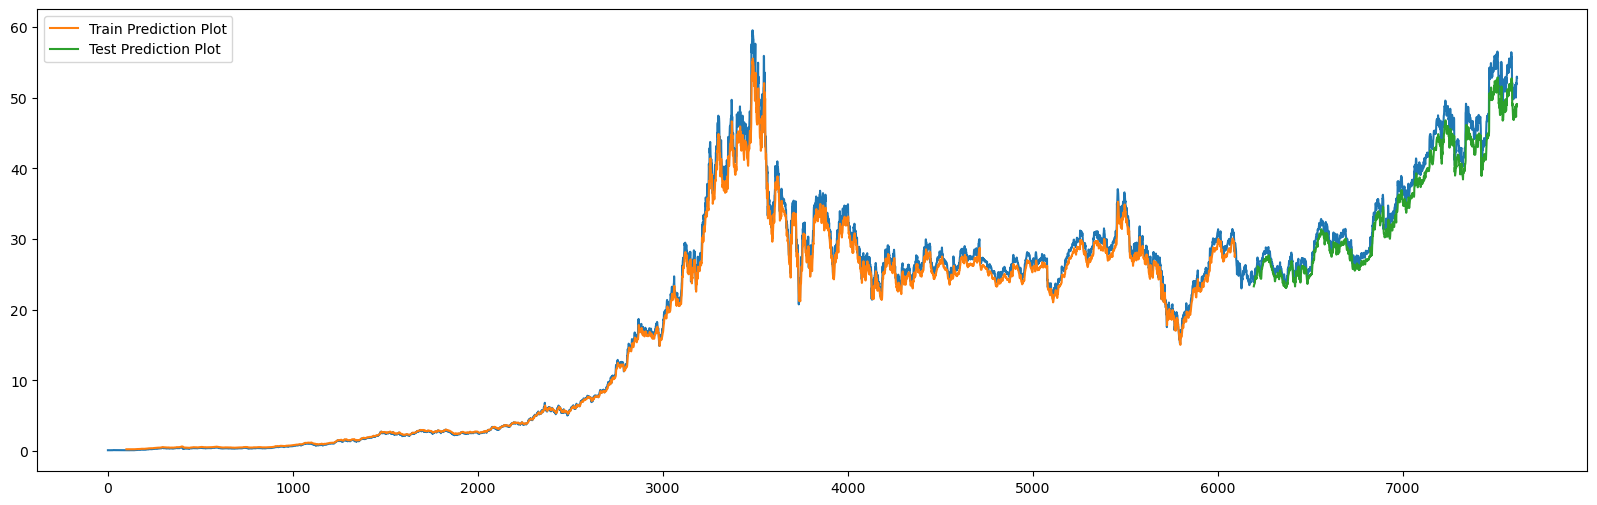

In [380]:
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot, label='Train Prediction Plot')
plt.plot(testPredictPlot, label='Test Prediction Plot')
plt.legend()
plt.show();

## Forecast